# Assignment 4

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

---
### 4.1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import copy
import cv2


In [2]:
%matplotlib tk


image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q1/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

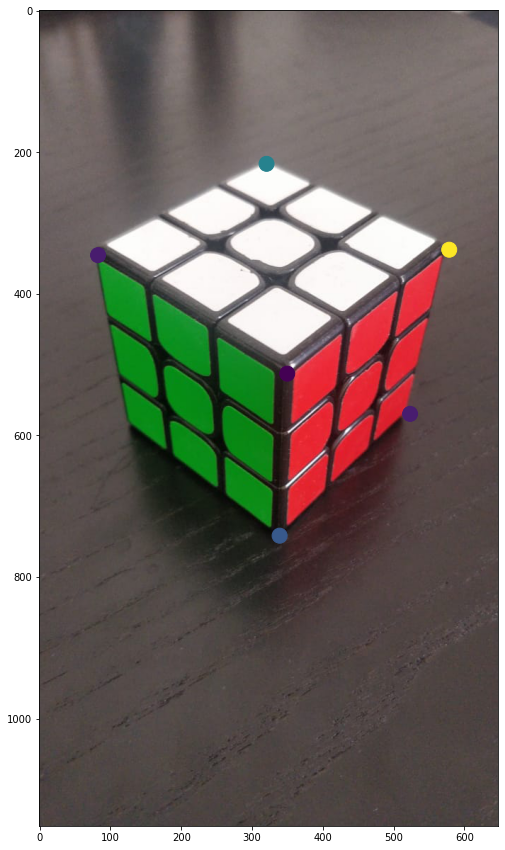

In [4]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [ ]:
corresponding_points = np.array([[image_points[0],np.array([0,4.0,0])],
                                 [image_points[1],np.array([0,0,0])],
                                 [image_points[2],np.array([4.0,0,0])],
                                 [image_points[3],np.array([4.0,4.0,0])],
                                 [image_points[4],np.array([0,0,-4.0])],
                                 [image_points[5],np.array([4.0,0,-4.0])]],dtype=object)
print(corresponding_points)

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [6]:
def get_ax(c_points,i):
    ax = np.empty((12,1))
    ax[:3] = -np.array([c_points[i][1]]).T
    ax[3] = -1.0
    ax[4:8] = np.array([[0,0,0,0]]).T
    ax[8:11] = c_points[i][0][0]*np.array([c_points[i][1]]).T
    ax[11] = c_points[i][0][0]
    return ax

def get_ay(c_points,i):
    ay = np.empty((12,1))
    ay[:4] = np.array([[0,0,0,0]]).T
    ay[4:7] = -np.array([c_points[i][1]]).T
    ay[7] = -1.0
    ay[8:11] = c_points[i][0][1]*np.array([c_points[i][1]]).T
    ay[11] = c_points[i][0][1]
    return ay

def generate_coefficient_mat(c_points):
    M = np.empty((12,12))
    for i,point in enumerate(c_points):
        M[2*i] = get_ax(c_points,i).T
        M[2*i+1] = get_ay(c_points,i).T
    return M

def DLT(c_points):
    M = generate_coefficient_mat(corresponding_points) 
    u, s, vh = np.linalg.svd(M, full_matrices=True)
    v = vh.T
    p = v[:,-1]
    p = p.reshape(3,4)
    return p

In [7]:
P = DLT(corresponding_points)
print(P)

[[-1.34324188e-01  9.86200112e-02  3.47672867e-02 -5.45502514e-01]
 [ 4.20437164e-02  4.17318825e-02  1.74595311e-01 -7.99658771e-01]
 [-7.84437285e-05 -6.86770732e-05  1.15515671e-04 -1.55845186e-03]]


### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

<img src="./img/1.png">
<img src="./img/2.png">
<img src="./img/3.png">
<img src="./img/4.png">

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [8]:
#Get reprojected points
def get_points(P, X):
    X = np.hstack((X,1))
    x = np.matmul(P,X)
    x = x/x[-1]
    return x
#Get reprojection error
def get_err(x, X, P):
    x_exp = get_points(P,X)
    return (x_exp[0]-x[0])**2 + (x_exp[1]-x[1])**2

In [9]:
for point in corresponding_points:
    x = point[0]
    X = point[1]
    print("Reprojection Error is:", get_err(x, X, P))

Reprojection Error is: 0.023515712941652736
Reprojection Error is: 0.2416463572324012
Reprojection Error is: 0.16668692926672185
Reprojection Error is: 0.017139742322787747
Reprojection Error is: 0.05857050057296825
Reprojection Error is: 0.04389499448470895


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [10]:
def ret_RKT(P):
    H = P[:,:3]
    h = np.array([P[:,-1]]).T
    Hinv = np.linalg.inv(H)
    C = np.matmul(Hinv,h)
    q , r = np.linalg.qr(Hinv)
    R = q.T
    K = np.linalg.inv(r)
    rot_pi = np.array([[-1,0,0],
                       [0,-1,0],
                       [0,0,1]])
    R = np.matmul(rot_pi,R)
    K = np.matmul(K,rot_pi)
    T = np.matmul(R,C)
    return R,K,T
    
R, K, T = ret_RKT(P)

#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [11]:
Pexp = np.matmul(K,np.hstack((R,T)))
np.isclose(Pexp,P)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

**Reproject the world points with P matrix you have obtained via DLT and visualize**

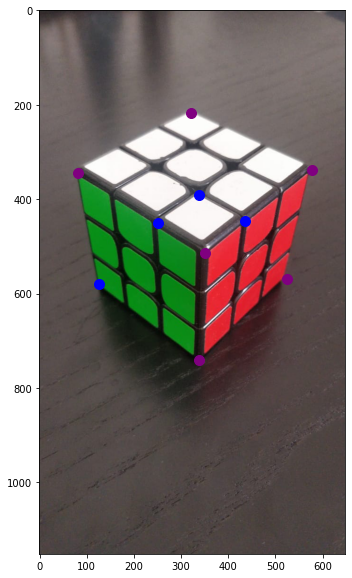

In [12]:
projected_points = []
w_points = np.array([[4/3,0,0],
                     [0,4/3,0],
                     [4/3,4/3,0],
                     [0,4,-4]])
for point in w_points:
    X = point
    x = get_points(P,X) 
    ix = x[0]
    iy = x[1]
    projected_points.append([ix,iy])
    
for point in corresponding_points:
    X = point[1]
    x = get_points(P,X) 
    ix = x[0]
    iy = x[1]
    projected_points.append([ix,iy])
    
projected_points = np.array(projected_points)
fig = plt.figure(figsize=(8,10))
plt.imshow(img)
plt.scatter(projected_points[:4,0], projected_points[:4,1],c="blue",s=100)
plt.scatter(projected_points[4:,0], projected_points[4:,1],c="purple",s=100)

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [ ]:
import numpy as np
import cv2 as cv
import glob
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

objpoints = [] 
imgpoints = [] 
images = glob.glob('*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(500)
cv.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

---
### 4.2 Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

In [87]:
%matplotlib tk

In [89]:
%matplotlib tk
img1 = mpimg.imread('q2/img1.jpg')
img2 = mpimg.imread('q2/img2.jpg')

im1_points = []
im2_points = []

In [90]:
def onclick(event):
    ix, iy = event.xdata, event.ydata
    im1_points.append([ix, iy])
    
fig = plt.figure(figsize=(20,30))
cid = fig.canvas.mpl_connect('button_press_event', onclick)
implot = plt.imshow(img1)
plt.show()

In [91]:
def onclick(event):
    ix, iy = event.xdata, event.ydata
    im2_points.append([ix, iy])
    
fig = plt.figure(figsize=(20,30))
cid = fig.canvas.mpl_connect('button_press_event', onclick)
implot = plt.imshow(img2)
plt.show()

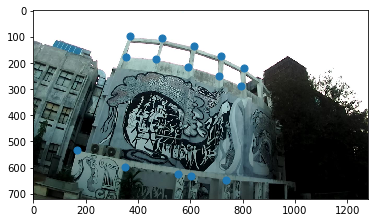

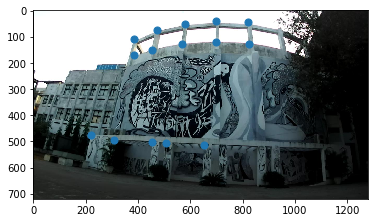

In [92]:
%matplotlib inline
im1_points = np.array(im1_points)
plt.figure()
plt.imshow(img1)
plt.scatter(im1_points[:,0], im1_points[:,1],s = 50)
plt.show()
im2_points = np.array(im2_points)
plt.figure()
plt.imshow(img2)
plt.scatter(im2_points[:,0], im2_points[:,1],s = 50)
plt.show()

In [93]:
im1_org = copy.deepcopy(im1_points)
im2_org = copy.deepcopy(im2_points)

In [94]:
def make_homogeneous(p):
    x = copy.deepcopy(p)
    return np.hstack((x,np.ones((x.shape[0],1))))
im1 = make_homogeneous(im1_org)
im2 = make_homogeneous(im2_org)


In [97]:
def get_fundamental_matrix(x1,x2):
    A = np.zeros((x1.shape[0],9))
    for i in range(x1.shape[0]):
        a = np.kron(x1[i],x2[i])
        A[i,:] = a
    u,s,vh = np.linalg.svd(A)
    Fa = vh.T[:,-1]
    Fa = Fa.reshape(3,3)
    
    ua,sa,vha = np.linalg.svd(Fa)
    sa[-1] = 0
    F = np.matmul(ua,np.matmul( np.diag(sa),vha))
    return F

In [98]:
F = get_fundamental_matrix(im1,im2)
print(im1)

[[367.67204301  96.22258065   1.        ]
 [491.54301075 106.54516129   1.        ]
 [613.12007168 134.07204301   1.        ]
 [717.49283154 174.21541219   1.        ]
 [803.51433692 218.94659498   1.        ]
 [353.90860215 177.6562724    1.        ]
 [467.45698925 186.83189964   1.        ]
 [592.47491039 215.50573477   1.        ]
 [708.3172043  249.91433692   1.        ]
 [794.33870968 290.05770609   1.        ]
 [166.95519713 534.35878136   1.        ]
 [348.17383513 598.58817204   1.        ]
 [552.33154122 623.82114695   1.        ]
 [602.79749104 631.84982079   1.        ]
 [734.69713262 649.05412186   1.        ]]


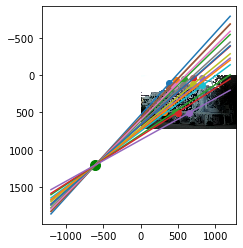

In [118]:
plt.imshow(img2)
l = []
for i,p in enumerate(im1):
    l2 = np.matmul(F.T,p)
    l.append(l2)
    plt.scatter(im2[i][0],im2[i][1])
    plt.plot([1200,-1200],[-(l2[2]+1200*l2[0])/l2[1],-(l2[2]-1200*l2[0])/l2[1]])
l = np.array(l)
px2 = l[0][1]*l[1][2] - l[1][1]*l[0][2] 
px2 = px2/(l[0][0]*l[1][1] - l[1][0]*l[0][1])
py2 = l[1][0]*l[0][2] - l[0][0]*l[1][2] 
py2 = py2/(l[0][0]*l[1][1] - l[1][0]*l[0][1])
plt.scatter(px2,py2,c="g",s=100)

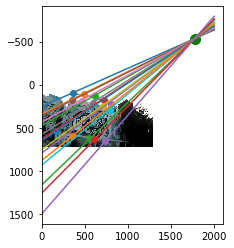

In [119]:
plt.imshow(img1)
l = []
for i,p in enumerate(im2):
    l2 = np.matmul(F,p)
    l.append(l2)
    plt.scatter(im1[i][0],im1[i][1])
    plt.plot([2000,0],[-(l2[2]+2000*l2[0])/l2[1],-(l2[2])/l2[1]])
l = np.array(l)
px1 = l[0][1]*l[1][2] - l[1][1]*l[0][2] 
px1 = px1/(l[0][0]*l[1][1] - l[1][0]*l[0][1])
py1 = l[1][0]*l[0][2] - l[0][0]*l[1][2] 
py1 = py1/(l[0][0]*l[1][1] - l[1][0]*l[0][1])
plt.scatter(px1,py1,c="g",s=100)

**Provide a clear explanation on your approach for both this task and the next**

#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

In [120]:
print(f" Epipole in Image 1 : x={px1} y={py1}")
print(f" Epipole in Image 2 : x={px2} y={py2}")

 Epipole in Image 1 : x=1773.4347085264474 y=-533.5186837462775
 Epipole in Image 2 : x=-606.6815311434196 y=1205.7487211305645


### Mathematical Calculations :Already done in previous part ⬆️

____
### 4.3 Drawing a bounding box around a car and localizing it in the camera frame
You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)

In [62]:
%matplotlib tk

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print([ix, iy])

img = mpimg.imread("./q3/image.png")
fig = plt.figure(figsize=(20,30))
cid = fig.canvas.mpl_connect('button_press_event', onclick)
implot = plt.imshow(img)
plt.show()

[835.2903225806451, 311.0386290322581]


In [122]:
ix,iy = 835.2903225806451, 311.0386290322581

h = 1.38
w = 1.51
l = 4.10

K = np.array([ [7.2153e+02,0,6.0955e+02],[0,7.2153e+02,1.7285e+02],[0,0,1]])

P = np.zeros((3,4))


P[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]]) ### no rotation
P[:3,-1] = -np.matmul(P[:3,:3],np.array([[0,0,1.65]]).T).T
# print(P)

P = np.matmul(K,P)
print(P)

[[ 7.2153000e+02 -6.0955000e+02  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.7285000e+02  7.2153000e+02 -1.1905245e+03]
 [ 0.0000000e+00 -1.0000000e+00  0.0000000e+00  0.0000000e+00]]


$$ 
x = \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}\\
y = \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}\\
$$
Here $Z = 0 $ giving
$$
(p_{31}x-p_{11})X + (p_{32}x-p_{12})Y = p_{14}-p_{34}x\\
(p_{31}y-p_{21})X + (p_{32}y-p_{22})Y = p_{24}-p_{34}y
$$
On solving for $X,Y$ we get
$$
X = \frac{(p_{32}x-p_{12})(-p_{24}+p_{34}y)-(p_{32}y-p_{22})(-p_{14}+p_{34}x)}{(p_{31}x-p_{11})(p_{32}y-p_{22})-(p_{31}y-p_{21})(p_{32}x-p_{12})}\\
Y = \frac{(p_{31}y-p_{21})(-p_{14}+p_{34}x)-(p_{31}x-p_{11})(-p_{24}+p_{34}y)}{(p_{31}x-p_{11})(p_{32}y-p_{22})-(p_{31}y-p_{21})(p_{32}x-p_{12})}
$$

In [130]:
X = (P[2,1]*iy - P[0,2])*(P[1,3]-P[2,3]*iy) - (P[2,1]*iy - P[1,1])*(P[0,3]-P[2,3]*ix) 
X = X/( (P[2,0]*ix - P[0,0])*(P[2,1]*iy - P[1,1]) - (P[2,0]*iy - P[1,0])*(P[2,1]*ix-P[0,2]) )
Y = -(P[2,0]*ix - P[1,0])*(P[0,3]-P[2,3]*ix) + (P[2,0]*ix - P[0,0])*(P[1,3]-P[2,3]*iy) 
Y = Y/( (P[2,0]*ix - P[0,0])*(P[2,1]*iy - P[1,1]) - (P[2,0]*iy - P[1,0])*(P[2,1]*ix-P[0,2]) )
X = -1*X

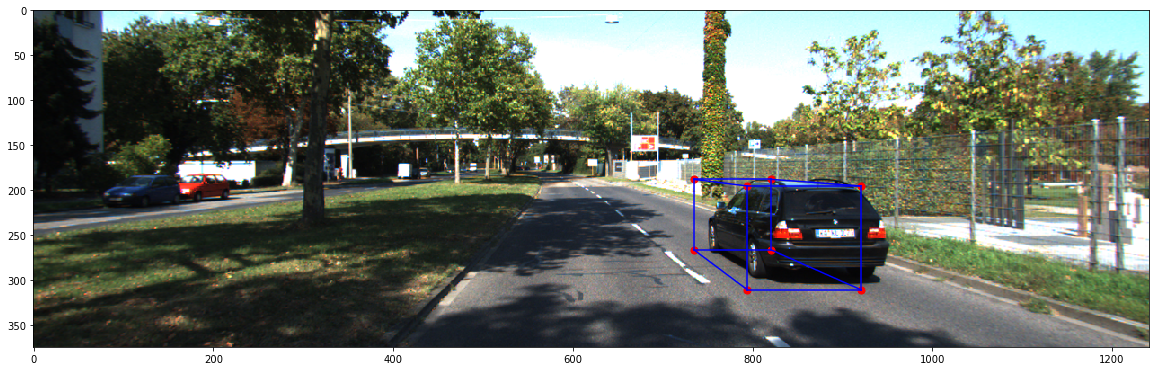

In [131]:
%matplotlib inline

w_points = np.array([[X,Y,0],
                    [X,Y+l,0],
                    [X+w,Y,0],
                    [X+w,Y+l,0],
                    [X,Y,h],
                    [X,Y+l,h],
                    [X+w,Y,h],
                    [X+w,Y+l,h]]) 
proj_points = []
for p in w_points:
    p_ = np.hstack((p,1))
    proj_p = np.dot(P,p_.T)
    proj_p = proj_p/proj_p[-1]
    proj_points.append([proj_p[0],proj_p[1]])

proj_points = np.array(proj_points)
plt.figure(figsize=(20,20))
img=mpimg.imread('./q3/image.png')
plt.imshow(img)
plt.scatter(proj_points[:,0],proj_points[:,1],c = "r",s=50)
p = proj_points
plt.plot([p[0][0],p[1][0]],[p[0][1],p[1][1]],c="b")
plt.plot([p[2][0],p[3][0]],[p[2][1],p[3][1]],c="b")
plt.plot([p[0][0],p[2][0]],[p[0][1],p[2][1]],c="b")
plt.plot([p[1][0],p[3][0]],[p[1][1],p[3][1]],c="b")

plt.plot([p[4][0],p[5][0]],[p[4][1],p[5][1]],c="b")
plt.plot([p[6][0],p[7][0]],[p[6][1],p[7][1]],c="b")
plt.plot([p[4][0],p[6][0]],[p[4][1],p[6][1]],c="b")
plt.plot([p[5][0],p[7][0]],[p[5][1],p[7][1]],c="b")

plt.plot([p[0][0],p[4][0]],[p[0][1],p[4][1]],c="b")
plt.plot([p[1][0],p[5][0]],[p[1][1],p[5][1]],c="b")
plt.plot([p[2][0],p[6][0]],[p[2][1],p[6][1]],c="b")
plt.plot([p[3][0],p[7][0]],[p[3][1],p[7][1]],c="b")
imgplot = plt.imshow(img)
plt.show()